In [ ]:
#  This cell loads the batch job from bedrock. It returns the extracted tasks for each
#  job.
from llmbo import StructuredBatchInferer
from extraction import TaskOutput


sbi = StructuredBatchInferer.recover_structured_job(
    job_arn="arn:aws:bedrock:us-east-1:992382722318:model-invocation-job/7whskxnh15zc",
    region="us-east-1",
    output_model=TaskOutput,
)

sbi.download_results()
sbi.load_results()

print(len(sbi.instances))


2025-02-17 13:04:17,154 - llmbo.llmbo.StructuredBatchInferer - INFO - Attempting to Recover BatchInferer from arn:aws:bedrock:us-east-1:992382722318:model-invocation-job/7whskxnh15zc
2025-02-17 13:04:17,163 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2025-02-17 13:04:27,530 - llmbo.llmbo.StructuredBatchInferer - INFO - Initialized StructuredBatchInferer with TaskOutput schema
2025-02-17 13:04:27,531 - llmbo.llmbo.StructuredBatchInferer - INFO - Intialising BatchInferer
2025-02-17 13:04:27,540 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2025-02-17 13:04:39,003 - llmbo.llmbo.StructuredBatchInferer - INFO - Role 'BatchInferenceRole' exists.
2025-02-17 13:04:39,019 - llmbo.llmbo.StructuredBatchInferer - INFO - Initialized BatchInferer
2025-02-17 13:04:39,020 - llmbo.llmbo.StructuredBatchInferer - INFO - Job arn:aws:bedrock:us-east-1:992382722318:model-invocation-job/7whskxnh15zc is alr

23233


In [15]:
# Load the jobs dataframe

import pandas as pd

hmrc_jobs = pd.read_parquet("./data/jobs.pq")
hmrc_jobs = hmrc_jobs.loc[hmrc_jobs["department"] == "HM Revenue and Customs"].copy()

In [ ]:
#  convert the instances from the batch processor into a data frame
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

tasks_dict = {}
for item in sbi.instances:
    if item:
        # Extract vacancy_id from the recordId string
        vacancy_id = int(item["recordId"].split("=")[1])
        # Get the tasks from the outputModel
        if item["outputModel"]:
            tasks = item["outputModel"].model_dump()["tasks"]
            tasks_dict[vacancy_id] = tasks


tasks_df = pd.DataFrame(
    [{"vacancy_id": key, **item} for key, tasks in tasks_dict.items() for item in tasks]
).set_index("vacancy_id")


,task_number,task_details,exposure_score
vacancy_id,,,
8,1,"Review, update and rationalise current estates...",0.6
8,2,Integration of the VoA Estate into HMRC's estate,0.4
8,3,Strategic asset management with HMRC's estates...,0.5
8,4,Strategic level analysis and reporting on the ...,0.7
8,5,Provide specialist senior level property advic...,0.4
...,...,...,...
362370,2,Develop and engage team members while demonstr...,0.4
362370,3,Manage resources within a fast-paced work envi...,0.6
362370,4,Ensure delivery of operational outputs for Cus...,0.5


In [ ]:
# Supplement the job listings with the llm output task and exposure score.
hmrc_jobs_with_tasks = hmrc_jobs.merge(tasks_df, on="vacancy_id", how="left")


In [18]:
#  This computes the summary stats for each vacancy, i.e. how exposed the role is to automation
hmrc_stats = hmrc_jobs_with_tasks.groupby("vacancy_id")["exposure_score"].agg(
    ["count", "mean", "median", "std"]
)


In [21]:
hmrc_with_stats = hmrc_jobs.merge(hmrc_stats, how="left", on="vacancy_id")


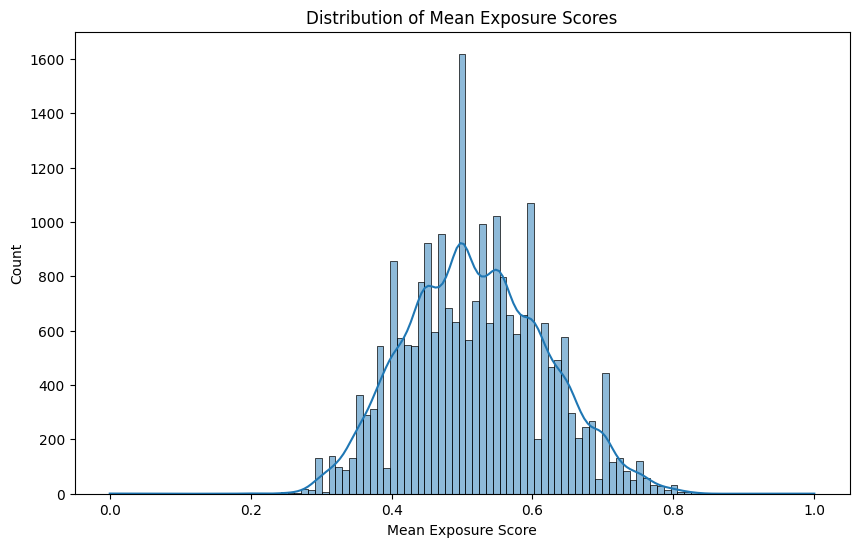

In [22]:
# Create a distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(data=hmrc_stats["mean"], kde=True)
plt.title("Distribution of Mean Exposure Scores")
plt.xlabel("Mean Exposure Score")
plt.ylabel("Count")
plt.show()


In [33]:
# Concentrating on the roles where their is a high degree of automation potential
high_degree_of_automation_potential = hmrc_jobs.merge(
    hmrc_stats[hmrc_stats["mean"] >= 0.7], how="right", on="vacancy_id"
)


print(f"{len(high_degree_of_automation_potential)} of {len(hmrc_jobs)} are HIGH")
print(
    f"{len(high_degree_of_automation_potential['vacancy_title'].str.lower().unique())} vacancy_titles"
)

1134 of 23233 are HIGH
947 vacancy_titles


In [ ]:
# We have a longish list of job titles, use an llm to uncover the groups.
from mirascope.core import Messages, bedrock
import boto3
from pydantic import BaseModel, Field
from typing import List

taxonomy_prompt = """
You are an expert in creating groups of similar job titles. You examine the full list of 
job titles. Create a list of groups which cover the full list. 
"""


class JobTitleTaxonomy(BaseModel):
    categories: List[str] = Field(..., description="A list of the job categories")


@bedrock.call(
    "us.anthropic.claude-3-5-sonnet-20241022-v2:0",
    call_params={"temperature": 0.2, "max_tokens": 8000},
    client=boto3.Session().client("bedrock-runtime", region_name="us-east-1"),
    response_model=JobTitleTaxonomy,
)  # type: ignore
def map_jobs(job_titles: str) -> Messages.Type:
    return [
        Messages.System(taxonomy_prompt),
        Messages.User(f"""
            Group these job titles:  
            <job_titles>{job_titles}</job_titles>
            """),
    ]


job_groupings = map_jobs(
    "\n".join(high_degree_of_automation_potential["vacancy_title"].str.lower().unique())
)

job_groupings.categories


2025-02-17 13:24:54,496 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


['Data & Analytics',
 'Administrative & Support',
 'Finance & Accounting',
 'Project & Program Management',
 'Customer Service',
 'Technical & IT',
 'HR & Recruitment',
 'Compliance & Risk',
 'Management & Leadership',
 'Legal & Policy',
 'Communications & Marketing',
 'Operations']

In [ ]:
# Now that the model has created a taxonomy/groupings of the roles. Use those and map
# each of the roles.

from enum import Enum
from llmbo import ModelInput
from datetime import datetime

# # Create the Enum dynamically
# Category = Enum("JobCategories", job_groupings.categories)

Category = Enum("JobCategories", ['Data & Analytics',
 'Administrative & Support',
 'Finance & Accounting',
 'Project & Program Management',
 'Customer Service',
 'Technical & IT',
 'HR & Recruitment',
 'Compliance & Risk',
 'Management & Leadership',
 'Legal & Policy',
 'Communications & Marketing',
 'Operations'])

SYSTEM_PROMPT = """
You are an expert in mapping job titles to categories provided
"""


def prompt(job_description):
    return f"""
    Map a single job title to the closest category provied.
    <job_title>{job_description}</job_title>
    """


class Mapper(BaseModel):
    mapped_category: Category


try:
    job_mapper_batcher = StructuredBatchInferer.recover_structured_job(
        job_arn="arn:aws:bedrock:us-east-1:992382722318:model-invocation-job/st34z39z3ckv",
        region="us-east-1",
        output_model=Mapper,
    )

    job_mapper_batcher.download_results()
    job_mapper_batcher.load_results()
except ValueError:
    # modify this to use a better model.
    job_mapper_batcher = StructuredBatchInferer(
        output_model=Mapper,
        model_name="us.anthropic.claude-3-5-sonnet-20241022-v2:0",
        region="us-east-1",
        job_name=f"hmrc-job-mapper-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
        bucket_name="cddo-af-bedrock-batch-inference-us-east-1",
        role_arn="arn:aws:iam::992382722318:role/BatchInferenceRole",
    )
    inputs = {
        f"vacancy_id={row.vacancy_id}": ModelInput(
            system=SYSTEM_PROMPT,
            messages=[{"role": "user", "content": prompt(row.job_description)}],
        )
        for row in high_degree_of_automation_potential.itertuples()
    }

    job_mapper_batcher.prepare_requests(inputs)
    job_mapper_batcher.push_requests_to_s3()
    job_mapper_batcher.create()
    job_mapper_batcher.poll_progress(60)

    job_mapper_batcher.download_results()
    job_mapper_batcher.load_results()


print(job_mapper_batcher.manifest)


2025-02-17 14:02:37,400 - llmbo.llmbo.StructuredBatchInferer - INFO - Attempting to Recover BatchInferer from arn:aws:bedrock:us-east-1:992382722318:model-invocation-job/st34z39z3ckv
2025-02-17 14:02:37,408 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2025-02-17 14:02:47,601 - llmbo.llmbo.StructuredBatchInferer - INFO - Initialized StructuredBatchInferer with Mapper schema
2025-02-17 14:02:47,602 - llmbo.llmbo.StructuredBatchInferer - INFO - Intialising BatchInferer
2025-02-17 14:02:47,611 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2025-02-17 14:03:10,205 - llmbo.llmbo.StructuredBatchInferer - INFO - Role 'BatchInferenceRole' exists.
2025-02-17 14:03:10,222 - llmbo.llmbo.StructuredBatchInferer - INFO - Initialized BatchInferer
2025-02-17 14:03:10,228 - llmbo.llmbo.StructuredBatchInferer - INFO - Job arn:aws:bedrock:us-east-1:992382722318:model-invocation-job/st34z39z3ckv is already

In [ ]:
mapped_job_titles = pd.DataFrame(
    [
        {
            "vacancy_id": int(item["recordId"].split("=")[1]),  # Extract ID
            "category": item["outputModel"].mapped_category.name,
        }
        for item in job_mapper_batcher.instances
    ]
)


high_degree_of_automation_potential = high_degree_of_automation_potential.merge(
    mapped_job_titles, on="vacancy_id", how="left"
)


In [ ]:
# Compute summary statistics for each job group
summary = (
    high_degree_of_automation_potential.groupby("category")
    .apply(
        lambda g: pd.Series(
            {
                "count": g["count"].sum(),
                "mean": np.average(g["mean"], weights=g["count"]),  # Weighted mean
                "std": np.sqrt(
                    np.sum(
                        (g["count"] - 1) * (g["std"] ** 2)
                        + g["count"]
                        * (g["mean"] - np.average(g["mean"], weights=g["count"])) ** 2
                    )
                    / (g["count"].sum() - 1)  # Pooled standard deviation formula
                ),
            }
        )
    )
    .reset_index()
)

summary

/var/folders/qd/w6hx3h_971ncxf55m45p_wcc0000gp/T/ipykernel_50835/240458120.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = high_degree_of_automation_potential.groupby('category').apply(lambda g: pd.Series({


,category,count,mean,std
0,Administrative & Support,1913.0,0.728202,0.122236
1,Communications & Marketing,431.0,0.727146,0.121953
2,Compliance & Risk,227.0,0.726432,0.111920
3,Customer Service,302.0,0.723510,0.110659
4,Data & Analytics,663.0,0.730468,0.119337
5,Finance & Accounting,790.0,0.728734,0.117025
6,HR & Recruitment,693.0,0.726696,0.119517
7,Legal & Policy,83.0,0.726506,0.103569
8,Management & Leadership,156.0,0.728526,0.114411
9,Operations,75.0,0.744000,0.133041


In [ ]:
import plotly.express as px
import pandas as pd

# Create the scatter plot
fig = px.scatter(
    summary,
    x="mean",
    y="std",
    text="category",  # Show category as hover text
    size="count",  # Bubble size based on count
    hover_data={
        "category": True,
        "count": True,
        "mean": True,
        "std": True,
    },  # Display extra details
    title="Mean vs Standard Deviation by Job Category",
    labels={"mean": "Mean", "std": "Standard Deviation"},
)

# Improve layout
fig.update_traces(marker=dict(opacity=0.7, line=dict(width=1, color="black")))
fig.update_layout(
    xaxis=dict(title="Mean"), yaxis=dict(title="Standard Deviation"), showlegend=False
)

# Show the figure
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
other = StructuredBatchInferer.recover_structured_job(
    job_arn="arn:aws:bedrock:us-east-1:992382722318:model-invocation-job/st34z39z3ckv",
    region="us-east-1",
    output_model=Mapper,
)

2025-02-17 13:57:33,541 - llmbo.llmbo.StructuredBatchInferer - INFO - Attempting to Recover BatchInferer from arn:aws:bedrock:us-east-1:992382722318:model-invocation-job/st34z39z3ckv
2025-02-17 13:57:33,560 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2025-02-17 13:57:42,593 - llmbo.llmbo.StructuredBatchInferer - INFO - Initialized StructuredBatchInferer with Mapper schema
2025-02-17 13:57:42,594 - llmbo.llmbo.StructuredBatchInferer - INFO - Intialising BatchInferer
2025-02-17 13:57:42,602 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2025-02-17 13:58:05,511 - llmbo.llmbo.StructuredBatchInferer - INFO - Role 'BatchInferenceRole' exists.
2025-02-17 13:58:05,529 - llmbo.llmbo.StructuredBatchInferer - INFO - Initialized BatchInferer


In [77]:
if other:
    print("yeah")

yeah


In [ ]:
noother = StructuredBatchInferer.recover_structured_job(
    job_arn="arn:aws:bedrock:us-east-1:992382722318:model-invocation-job/st34z39z3ckw",
    region="us-east-1",
    output_model=Mapper,
)

2025-02-17 14:00:32,481 - llmbo.llmbo.StructuredBatchInferer - INFO - Attempting to Recover BatchInferer from arn:aws:bedrock:us-east-1:992382722318:model-invocation-job/st34z39z3ckw
2025-02-17 14:00:32,492 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2025-02-17 14:00:41,273 - llmbo.llmbo.StructuredBatchInferer - ERROR - Job not found: arn:aws:bedrock:us-east-1:992382722318:model-invocation-job/st34z39z3ckw


ValueError: Job not found: arn:aws:bedrock:us-east-1:992382722318:model-invocation-job/st34z39z3ckw